# Agreement between manual classifications and deep neural network

In [1]:
!pwd

/mnt/lustre02/work/mh0010/m300408/CharacterizationOfMesoscalePatterns/Classification/NN-application/NN_agreement_analysis


In [2]:
!which python

/sw/spack-rhel6/jupyterhub/jupyterhub/bin/python


In [3]:
domain = [10, 24, -61, -40]  # domain of original data [lat1, lat2, lon1, lon2]
lat0, lat1, lon0, lon1 = [10, 20, -58, -48]
label_map= {'Sugar':0, 'Fish': 3, 'Flowers': 2, 'Flower': 2, 'Gravel': 1}
label_map_rv = {0:'Sugar', 1:'Gravel', 2: 'Flowers', 3: 'Fish'}
color_dict = {'Sugar':'#A1D791','Fish':'#2281BB','Gravel':'#3EAE47', 'Flowers': '#93D2E2'}
frequency_threshold = 0.1

In [4]:
fn_ABI_IR = '/mnt/lustre02/work/mh0010/m300408/CharacterizationOfMesoscalePatterns/Data/Level_1/GOES16_CH13_classifications_2018-2020_NDJFM_30min.zarr/' #" ABIonICONdomain_DOM01.zarr'
files_manualClassifications_l3 = {
   "manualVIS": '/work/mh0010/m300408/EUREC4A_CloudClassification/manual/processed_data/EUREC4A_ManualClassifications_l3_VIS.zarr',
   "manualIR": '/work/mh0010/m300408/EUREC4A_CloudClassification/manual/processed_data/EUREC4A_ManualClassifications_l3_IR.zarr',
   "manualICON": '/work/mh0010/m300408/EUREC4A_CloudClassification/manual/processed_data/EUREC4A_ManualClassifications_l3_albedo.zarr' 
}
fn_iorg = '/work/mh0010/m300408/EUREC4A_CloudClassification/metrics/GOES16_IR_nc_Iorg_EUREC4A_10-20_-58--48.nc'

In [5]:
%load_ext autoreload
%autoreload 2
import tqdm
import dask
import zarr
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Circle, Wedge, Polygon
from matplotlib.collections import PatchCollection
import datetime as dt
import pandas as pd

import sys, os
sys.path.append("/home/mpim/m300408/CloudClassification/sugar-flower-fish-or-gravel")
from pyclouds.imports import *
from pyclouds.helpers import *
from pyclouds.zooniverse import *
from pyclouds.plot import *

del tqdm
import tqdm

sys.path.append(".")
import glob
from helpers import *

In [6]:
pd.__version__

'1.3.4'

## Calculate IoUs and compute classification mask

In [7]:
### Open neural network classifications
mask_ABI_IR = xr.open_zarr(fn_ABI_IR)

In [ ]:
for workflow, l3_file in files_manualClassifications_l3.items():
    ### Open manual classifications
    if '.zarr' in l3_file:
        mask_manual_classifications = xr.open_zarr(l3_file)
    elif '.nc' in l3_file:
        mask_manual_classifications = xr.open_dataset(l3_file)
    else:
        print('File format not supported')
    
    # find common times
    time_set_A = set(mask_ABI_IR.time.dt.floor(freq='1T').values)
    time_set_B = set(mask_manual_classifications.date.values)
    common_dates = np.array([*time_set_A.intersection(time_set_B)])
    times_of_interest = sorted(np.unique(common_dates))

    time_mask_ABIIR = np.in1d(mask_ABI_IR.time.dt.floor(freq='1T').values,common_dates)

    mask_ABI_IR_timesel = mask_ABI_IR.sel(time=time_mask_ABIIR)
    mask_ABI_IR_timesel['date'] = mask_ABI_IR_timesel.time.dt.floor(freq='1T')

    mask_manual_timesel = mask_manual_classifications.sel(date=common_dates)

    results = {}

    print("Find common times to all datasets")
    sizes_calculated = False

    for ii, i in enumerate(tqdm.tqdm(range(len(times_of_interest)))):
        if ii > 12: continue
        mask_ABI_IR_timestep = mask_ABI_IR_timesel.where(mask_ABI_IR_timesel.date == times_of_interest[i], drop=True)
        mask_manual_timestep = mask_manual_timesel.sel(date=times_of_interest[i])



        mask_ABI_IR_timestep = mask_ABI_IR_timestep.sel(latitude=slice(lat1, lat0),longitude=slice(lon0, lon1))
        mask_manual_timestep = mask_manual_timestep.sel(latitude=slice(lat1, lat0),longitude=slice(lon0, lon1))

        if sizes_calculated is False:
            size_ABI = len(mask_ABI_IR_timestep.latitude)*len(mask_ABI_IR_timestep.longitude)
            size_manual = len(mask_manual_timestep.latitude)*len(mask_manual_timestep.longitude)
            sizes_calculated = True

    # for d, date in enumerate(tqdm.tqdm(dates_in_all_datasets)):
        pattern_results = {}

        for pattern in ['Sugar', 'Gravel', 'Flowers', 'Fish']:
            arr_ABI = mask_ABI_IR_timestep.mask.sel(pattern=pattern)
            arr_manual = mask_manual_timestep.freq.sel(pattern=pattern)
            pattern_results[pattern] = {}

            merged_mask_ABI = merge_mask(arr_ABI)
            merged_mask_manual = arr_manual > frequency_threshold

            merged_mask_ABI = merged_mask_ABI.fillna(False).astype(bool).load()
            merged_mask_manual = merged_mask_manual.load()

            pattern_results[pattern]["area_fraction_ABI"] = np.count_nonzero(merged_mask_ABI)/size_ABI
            pattern_results[pattern][f"area_fraction_{workflow}"] = np.count_nonzero(merged_mask_manual)/size_manual

            iou_ABI_Manual = iou_one_class_from_annos(merged_mask_ABI.values,
                                                    merged_mask_manual.values,
                                                    return_iou = True)

            pattern_results[pattern][f"iou_ABI_{workflow}"] = iou_ABI_Manual
            pattern_results[pattern][f"missing_ABI_{workflow}"] = identify_where_class_missing(merged_mask_ABI,
                                                                                        merged_mask_manual)


        results[times_of_interest[i]] = pattern_results
    df = pd.DataFrame.from_dict(results, orient='index')
    df.to_pickle(f'agreement_results_ABI-IR_vs_{workflow}.pkl')

## Load computed data and merge with existing computations of other workflows

In [23]:
# Read output created by agreement_NN.py or the code section above
agreement_files = []
for workflow, _ in files_manualClassifications_l3.items():
    file = f"agreement_results_ABI-IR_vs_{workflow}.pkl"
    if os.path.isfile(file):
        agreement_files.append(f"agreement_results_ABI-IR_vs_{workflow}.pkl")

print(agreement_files)
dataframes = [None]*len(agreement_files)
for f,file in enumerate(agreement_files):
    dataframes[f] = pd.read_pickle(file)

['agreement_results_ABI-IR_vs_manualVIS.pkl', 'agreement_results_ABI-IR_vs_manualIR.pkl', 'agreement_results_ABI-IR_vs_manualICON.pkl']


In [24]:
df_all = pd.concat(dataframes);
df_all.head()

,Sugar,Gravel,Flowers,Fish
2020-01-07 02:00:00,"{'area_fraction_ABI': 0.0, 'area_fraction_manu...","{'area_fraction_ABI': 0.82656, 'area_fraction_...","{'area_fraction_ABI': 0.0, 'area_fraction_manu...","{'area_fraction_ABI': 0.0, 'area_fraction_manu..."
2020-01-07 04:00:00,"{'area_fraction_ABI': 0.0, 'area_fraction_manu...","{'area_fraction_ABI': 0.9, 'area_fraction_manu...","{'area_fraction_ABI': 0.0, 'area_fraction_manu...","{'area_fraction_ABI': 0.0, 'area_fraction_manu..."
2020-01-07 06:00:00,"{'area_fraction_ABI': 0.0, 'area_fraction_manu...","{'area_fraction_ABI': 0.784131, 'area_fraction...","{'area_fraction_ABI': 0.0, 'area_fraction_manu...","{'area_fraction_ABI': 0.0, 'area_fraction_manu..."
2020-01-07 08:00:00,"{'area_fraction_ABI': 0.0, 'area_fraction_manu...","{'area_fraction_ABI': 0.800765, 'area_fraction...","{'area_fraction_ABI': 0.0, 'area_fraction_manu...","{'area_fraction_ABI': 0.0, 'area_fraction_manu..."
2020-01-07 10:00:00,"{'area_fraction_ABI': 0.0, 'area_fraction_manu...","{'area_fraction_ABI': 0.817747, 'area_fraction...","{'area_fraction_ABI': 0.0, 'area_fraction_manu...","{'area_fraction_ABI': 0.0, 'area_fraction_manu..."


In [25]:
# Restrict analysis by time period
mask = (df_all.index >= '2020-01-07') & (df_all.index <= '2020-02-22')
# IOP
#20 January and 20 February 2020
# mask = (df_all.index >= '2020-01-20') & (df_all.index <= '2020-02-20')

In [26]:
df_all = df_all.loc[mask]

In [27]:
Sugar_df = df_all.Sugar.apply(pd.Series)
Gravel_df = df_all.Gravel.apply(pd.Series)
Flowers_df = df_all.Flowers.apply(pd.Series)
Fish_df = df_all.Fish.apply(pd.Series)

In [28]:
for df,p in zip([Sugar_df, Gravel_df, Fish_df, Flowers_df], ['Sugar','Gravel','Fish','Flowers']):
    rename_dict = {}
    for c in df.columns:
        rename_dict[c]=p+"_"+c
    df.rename(columns=rename_dict, inplace=True)

In [29]:
from functools import reduce
df_all = reduce(lambda  left,right: pd.merge(left,right,left_index=True,right_index=True,
                                            how='outer'), [Sugar_df, Gravel_df, Flowers_df, Fish_df])

In [30]:
df_all

,Sugar_area_fraction_ABI,Sugar_area_fraction_manualVIS,Sugar_iou_ABI_manualVIS,Sugar_missing_ABI_manualVIS,Sugar_area_fraction_manualIR,Sugar_iou_ABI_manualIR,Sugar_missing_ABI_manualIR,Sugar_area_fraction_manualICON,Sugar_iou_ABI_manualICON,Sugar_missing_ABI_manualICON,...,Fish_area_fraction_ABI,Fish_area_fraction_manualVIS,Fish_iou_ABI_manualVIS,Fish_missing_ABI_manualVIS,Fish_area_fraction_manualIR,Fish_iou_ABI_manualIR,Fish_missing_ABI_manualIR,Fish_area_fraction_manualICON,Fish_iou_ABI_manualICON,Fish_missing_ABI_manualICON
2020-01-07 02:00:00,0.0,0.0,NaN,3.0,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,NaN,3.0,NaN,NaN,NaN,NaN,NaN,NaN
2020-01-07 02:00:00,0.0,0.0,NaN,3.0,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,NaN,NaN,NaN,0.0,NaN,3.0,NaN,NaN,NaN
2020-01-07 02:00:00,0.0,0.0,NaN,3.0,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,3.0
2020-01-07 02:00:00,0.0,0.0,NaN,3.0,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,NaN,3.0,NaN,NaN,NaN,NaN,NaN,NaN
2020-01-07 02:00:00,0.0,0.0,NaN,3.0,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,NaN,NaN,NaN,0.0,NaN,3.0,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-01-08 02:00:00,0.0,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,3.0,...,0.0,NaN,NaN,NaN,0.0,NaN,3.0,NaN,NaN,NaN
2020-01-08 02:00:00,0.0,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,3.0,...,0.0,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,3.0
2020-01-08 02:00:00,0.0,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,3.0,...,0.0,0.0,NaN,3.0,NaN,NaN,NaN,NaN,NaN,NaN
2020-01-08 02:00:00,0.0,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,3.0,...,0.0,NaN,NaN,NaN,0.0,NaN,3.0,NaN,NaN,NaN


Note:
- nan values occur when the pattern has not been identified in any of the cases
- 0 occurs, if there has been no overlap between classes, which can also happen when one NN doesn't detect the pattern at all

## Area fractions

In [31]:
import matplotlib.pyplot as plt
import seaborn as sns

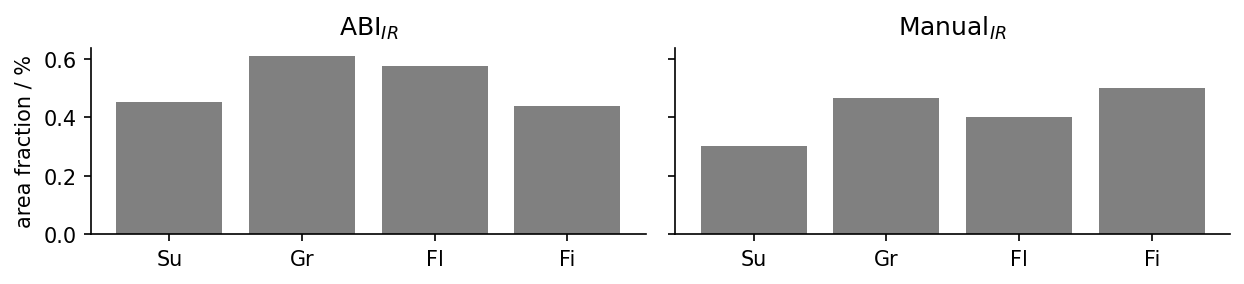

In [28]:
prop_dict = {
    "manualVIS":{
        'title': "Manual$_{VIS}$"
    },
    "manualIR":{
        'title': "Manual$_{IR}$"
    },
    "manualICON":{
        'title': "Manual$_{ICON}$"
    },
    "ABI":{
        'title': "ABI$_{IR}$"
    }
}
fig, axs = plt.subplots(1,2,figsize=(8.4,2),dpi=150,sharey=True)
for a,classification_approach in enumerate(["ABI", "manualVIS"]):
    means = {}
    for p, pattern in enumerate(['Sugar','Gravel','Flowers','Fish']):
        means[pattern]=df_all[pattern+'_area_fraction_'+classification_approach].loc[df_all[pattern+'_area_fraction_'+classification_approach] != 0].mean()
        axs[a].bar(p, means[pattern],color='grey')
    if a == 0:
        axs[a].set_ylabel('area fraction / %')
    axs[a].set_title(prop_dict[classification_approach]['title'])
    sns.despine()
    plt.tight_layout()
    axs[a].set_xticks([0,1,2,3])
    axs[a].set_xticklabels(['Su','Gr','Fl','Fi'])
# plt.savefig('areafraction_comparisons.pdf',bbox_inches="tight")

### Daily distribution

In [33]:
df_daily_mean = df_all.resample('1D').mean()

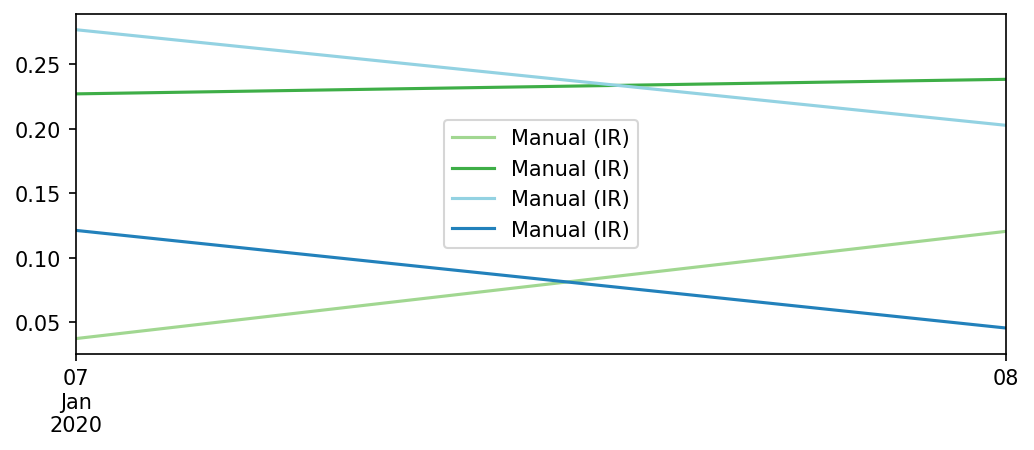

In [34]:
plt.figure(figsize=(8,3), dpi=150)
for pattern in ['Sugar', 'Gravel', 'Flowers', 'Fish']:
#     df_daily_mean[f'{pattern}_area_fraction_ABI'].plot(label='ABI', color=color_dict[pattern], linestyle='--')
    df_daily_mean[f'{pattern}_area_fraction_manualIR'].plot(label='Manual (IR)', color=color_dict[pattern], linestyle='-')
plt.legend()

In [35]:
df0 = df_all.filter(items=['Sugar_area_fraction_Manual','Gravel_area_fraction_Manual','Flowers_area_fraction_Manual','Fish_area_fraction_Manual']).rename(
    columns={'Sugar_area_fraction_Manual':'Sugar',
             'Gravel_area_fraction_Manual':'Gravel',
             'Flowers_area_fraction_Manual':'Flowers',
             'Fish_area_fraction_Manual':'Fish'})

In [36]:
df1 = df_daily_mean.filter(items=['Sugar_area_fraction_ABI','Gravel_area_fraction_ABI','Flowers_area_fraction_ABI','Fish_area_fraction_ABI']).rename(
    columns={'Sugar_area_fraction_ABI':'Sugar',
             'Gravel_area_fraction_ABI':'Gravel',
             'Flowers_area_fraction_ABI':'Flowers',
             'Fish_area_fraction_ABI':'Fish'})

In [37]:
df2 = df_daily_mean.filter(items=['Sugar_area_fraction_manualIR','Gravel_area_fraction_manualIR',
                                  'Flowers_area_fraction_manualIR','Fish_area_fraction_manualIR']).rename(
    columns={'Sugar_area_fraction_manualIR':'Sugar',
             'Gravel_area_fraction_manualIR':'Gravel',
             'Flowers_area_fraction_manualIR':'Flowers',
             'Fish_area_fraction_manualIR':'Fish'})

In [38]:
df3 = df_daily_mean.filter(items=['Sugar_area_fraction_manualVIS','Gravel_area_fraction_manualVIS',
                                  'Flowers_area_fraction_manualVIS','Fish_area_fraction_manualVIS']).rename(
    columns={'Sugar_area_fraction_manualVIS':'Sugar',
             'Gravel_area_fraction_manualVIS':'Gravel',
             'Flowers_area_fraction_manualVIS':'Flowers',
             'Fish_area_fraction_manualVIS':'Fish'})

In [39]:
df4 = df_daily_mean.filter(items=['Sugar_area_fraction_manualICON','Gravel_area_fraction_manualICON',
                                  'Flowers_area_fraction_manualICON','Fish_area_fraction_manualICON']).rename(
    columns={'Sugar_area_fraction_manualICON':'Sugar',
             'Gravel_area_fraction_manualICON':'Gravel',
             'Flowers_area_fraction_manualICON':'Flowers',
             'Fish_area_fraction_manualICON':'Fish'})

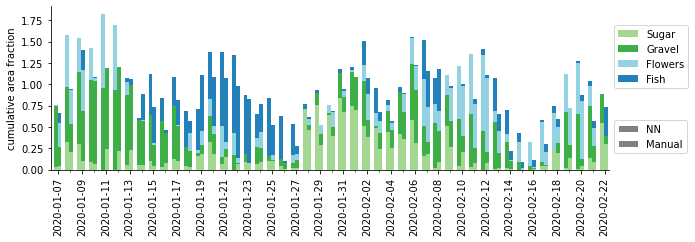

In [40]:
p=plot_clustered_stacked([df1, df2],["NN", "Manual IR"],title=None,figsize=(10,3),H=None, color_dict=color_dict)
p.set_ylabel('cumulative area fraction')
sns.despine()
plt.savefig('./figures/cumulative_area_fraction_ABIvsManual_dailyindividual2h.pdf', bbox_inches='tight')

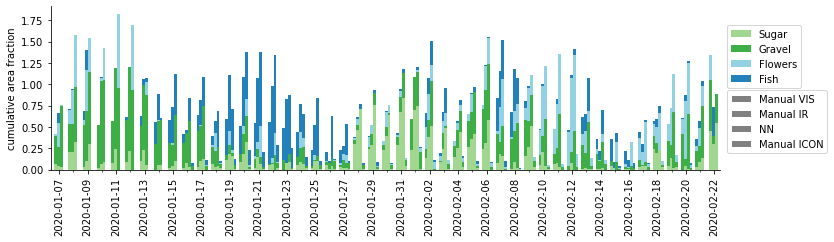

In [163]:
p=plot_clustered_stacked([df3, df2, df1, df4],["Manual VIS", "Manual IR", "NN", "Manual ICON"],
                         title=None,figsize=(12,3),H=None, color_dict=color_dict)
p.set_ylabel('cumulative area fraction')
sns.despine()
plt.savefig('./figures/cumulative_area_fraction_ManualVISvsManualIRvsNNvsICON_dailyindividual2h.pdf', bbox_inches='tight')

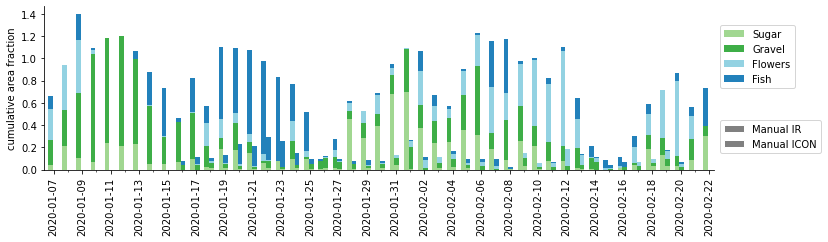

In [164]:
p=plot_clustered_stacked([df2, df4],["Manual IR", "Manual ICON"],
                         title=None,figsize=(12,3),H=None, color_dict=color_dict))
p.set_ylabel('cumulative area fraction')
sns.despine()
# plt.savefig('./figures/cumulative_area_fraction_ManualVISvsManualIRvsNNvsICON_dailyindividual2h.pdf', bbox_inches='tight')

## Where do IoUs of 0 come from?

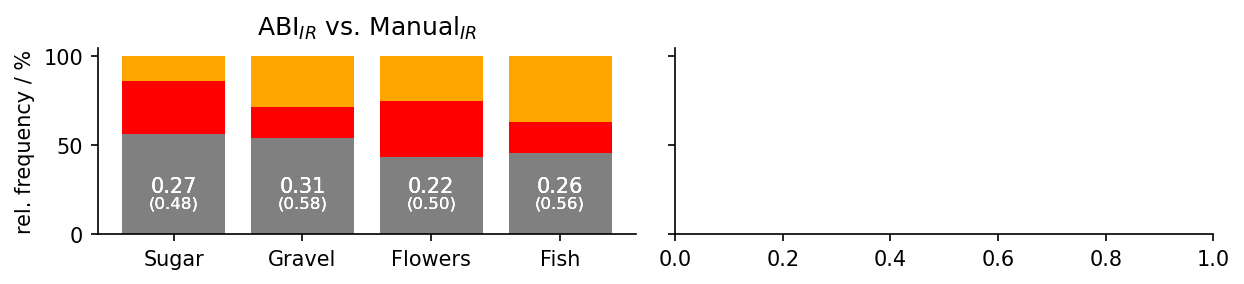

In [41]:
prop_dict = {
    "ABI_manualIR":{
        'colors': ['grey','red' , 'orange', 'green'],
        'title': 'ABI$_{IR}$ vs. Manual$_{IR}$'},
    "MVIS_AIR":{
        'colors': ['grey', 'blue','orange', 'green'],
        'title': 'MODIS$_{VIS}$ vs. ABI$_{IR}$'},
    "MIR_AIR":{
        'colors':['grey', 'red' ,'orange', 'green'],
        'title': 'MODIS$_{IR}$ vs. ABI$_{IR}$'}
    
}

relative = True
fig,axs = plt.subplots(1,2,figsize=(8.4,2),dpi=150,sharey=True)
for cc, classification_comparison in enumerate(["ABI_manualIR"]):
    colors = prop_dict[classification_comparison]['colors']
    means = {}
    for p, pattern in enumerate(['Sugar','Gravel','Flowers','Fish']):
        total = np.count_nonzero(np.where(df_all[pattern+'_missing_'+classification_comparison].dropna() != 3,True,False))
        if total == 0:
            continue
        counts = np.zeros(4)
        iou_without_zeros = df_all[pattern+'_iou_'+classification_comparison].loc[df_all[pattern+'_missing_'+classification_comparison] ==0].mean()
        iou_with_zeros = df_all[pattern+'_iou_'+classification_comparison].mean()
        for i_,i in enumerate([0,1,2,3]): #0: missing in none; 3: missing in both; 2:missing in the second (AIR)
            c=np.count_nonzero(np.where(df_all[pattern+'_missing_'+classification_comparison].dropna() == i,True,False))
            if relative:
                c = c/total*100
            counts[i_] = c
            if i == 3:
                continue
            if i_ == 0:
                axs[cc].bar(p, c, color=colors[i], label='no classifications')
            else:
                axs[cc].bar(p, c, bottom=np.sum(counts[0:i_]), color=colors[i])
            axs[cc].text(p,24, "{:3.2f}".format(iou_with_zeros),ha='center',color='white')
            axs[cc].text(p,15, "({:3.2f})".format(iou_without_zeros),ha='center',color='white',fontsize=8)
            axs[cc].set_title(prop_dict[classification_comparison]['title'])
    axs[cc].set_xticks([0,1,2,3])
    axs[cc].set_xticklabels(['Sugar','Gravel','Flowers','Fish'])
    if cc == 0:
        axs[cc].set_ylabel('rel. frequency / %')
    sns.despine()
    plt.tight_layout()
# plt.savefig(f'IOU_comparisons_mean_DOM0{DOM}.pdf',bbox_inches="tight")

## Comparison with Iorg

In [46]:
ds_iorg = xr.open_dataset(fn_iorg)

In [47]:
contaminated_dates = np.unique(ds_iorg.where(ds_iorg.percentile_Tb < 285, drop=True).time.dt.date)

In [48]:
ds_iorg_sel = ds_iorg.sel(time=~np.in1d(ds_iorg.time.dt.date,contaminated_dates), drop=True)
ds_iorg_sel = ds_iorg_sel.sel(time=np.in1d(ds_iorg_sel.time.dt.date,np.unique(df_all.index.date)))

In [49]:
ds_iorg_mean = ds_iorg_sel.groupby(ds_iorg_sel.time.dt.date).mean()
# ds_iorg_mean = ds_iorg.groupby(ds_iorg.time.dt.date).mean()

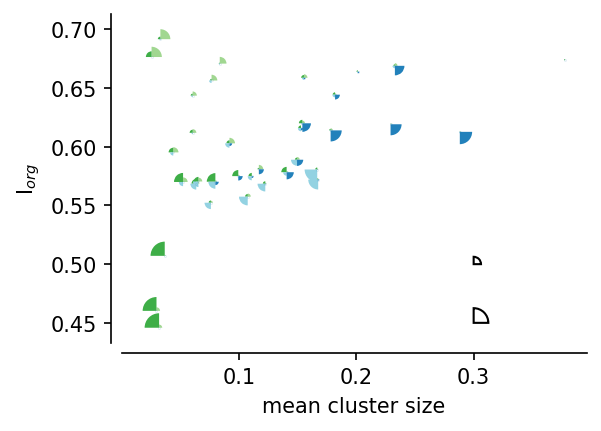

In [49]:
fig, ax = plt.subplots(figsize=(4,4),dpi=150)

patches = []



ax.plot(ds_iorg_mean.cluster_size_mean*500, ds_iorg_mean.Iorg,'.', markersize=0.1)
ax.set_aspect(1)

for t, (y,x) in enumerate(zip(ds_iorg_mean.cluster_size_mean.values*500, ds_iorg_mean.Iorg.values)):
#     if t>15:continue
    date = ds_iorg_mean.isel(date=t).date.values
    date = dt.datetime.combine(date.item(), dt.datetime.min.time())
    try:
        data = df2.loc[date]
    except KeyError:
        continue
# Some limiting conditions on Wedge
    for p_,pattern in enumerate(['Sugar','Gravel', 'Flowers','Fish']):
        w = Wedge((y, x), data[pattern]/80, p_*90, (p_+1)*90, fc=color_dict[pattern])

        ax.add_patch(w)

w = Wedge((.3, .45), 1/80, 0, 90, fc='white',ec='k', transform=ax.transData)
ax.add_patch(w)
w = Wedge((.3, .50), 0.5/80, 0, 90, fc='white',ec='k', transform=ax.transData)
ax.add_patch(w)

# p = PatchCollection(patches, alpha=1)
# ax.add_collection(p)
plt.xlabel('mean cluster size')
plt.ylabel('I$_{org}$')
sns.despine(offset=5)
# plt.savefig('./figures/Iorg_vs_S_hueManualClassifications.pdf', bbox_inches="tight")

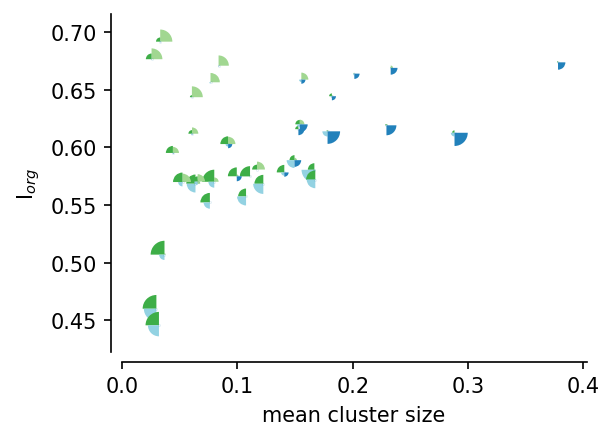

In [50]:
fig, ax = plt.subplots(figsize=(4,4),dpi=150)

patches = []



ax.plot(ds_iorg_mean.cluster_size_mean*500, ds_iorg_mean.Iorg,'.', markersize=0.1)
ax.set_aspect(1)

for t, (y,x) in enumerate(zip(ds_iorg_mean.cluster_size_mean.values*500, ds_iorg_mean.Iorg.values)):
#     if t>15:continue
    date = ds_iorg_mean.isel(date=t).date.values
    date = dt.datetime.combine(date.item(), dt.datetime.min.time())
    try:
        data = df1.loc[date]
    except KeyError:
        continue
# Some limiting conditions on Wedge
    for p_,pattern in enumerate(['Sugar','Gravel', 'Flowers','Fish']):
        w = Wedge((y, x), data[pattern]/80, p_*90, (p_+1)*90, fc=color_dict[pattern])

        ax.add_patch(w)


plt.xlabel('mean cluster size')
plt.ylabel('I$_{org}$')
sns.despine(offset=5)
# plt.savefig('./figures/Iorg_vs_S_hueNN.pdf', bbox_inches="tight")